# Antagonism

- This notebook contains code for the hate speech classification model.
- This is a sentiment analaysis problem.
- We will be using the Twitter dataset.
- The term hate speech is understood as any type of verbal, written or behavioural communication that attacks or uses derogatory or discriminatory language against a person or group based on what they are, in other words, based on their religion, ethnicity, nationality, race, colour, ancestry, sex or another identity factor.

### About the dataset
- The data set we will use for the hate speech detection model consists of a test and train set. The training package includes a list of 31,962 tweets, a corresponding ID and a tag 0 or 1 for each tweet. The particular sentiment we need to detect in this dataset is whether or not the tweet is based on hate speech

- 0: NotHate
- 1: Hate

### Importing libraries

In [1]:
import pandas as pd
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score


### Reading the Train and Test dataset 

In [2]:
train_data = pd.read_csv('dataset/train.csv')
test_data = pd.read_csv('dataset/test.csv')


In [3]:
# Reading first 15 rows of the training data
train_data.head(15)


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [4]:
# Size of dataset
print("Training Set:"% train_data.columns, train_data.shape) # 31962 rows for Training dataset
print("Testing Set:"% test_data.columns, test_data.shape)    # 171197 rows for Testing dataset


Training Set: (31962, 3)
Testing Set: (17197, 2)


### Dataset Visualization

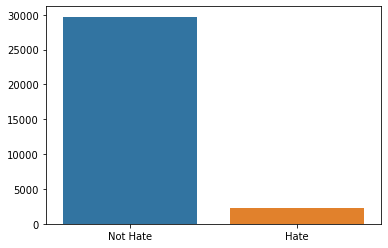

In [5]:
not_hate_count = len(train_data[train_data.label == 0])
hate_count = len(train_data[train_data.label == 1])

x = ["Not Hate", "Hate"]
y = [not_hate_count, hate_count]

sns.barplot(x, y)
plt.show()

### Cleaning the dataset 

In [6]:
def  clean_text(df, text_field): #
    # This function removes all unnecessary characters from the text
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df

train_clean = clean_text(train_data, "tweet")
test_clean = clean_text(test_data, "tweet")


In [7]:
# You can now see that the tweets are cleaned and readable
train_clean.head(15)


,id,label,tweet
0,1,0,when a father is dysfunctional and is so sel...
1,2,0,thanks for lyft credit i cant use cause they...
2,3,0,bihday your majesty
3,4,0,model i love u take with u all the time in u...
4,5,0,factsguide society now motivation
5,6,0,22 huge fan fare and big talking before they l...
6,7,0,camping tomorrow danny
7,8,0,the next school year is the year for exams can...
8,9,0,we won love the land allin cavs champions clev...
9,10,0,welcome here im its so gr8


In [8]:
# Getting count of Negative and Positive label from train dataset
print("The count for NOT HATE label from train dataset: ", len(train_clean[train_clean.label == 0]))
print("The count for HATE label from train dataset: ", len(train_clean[train_clean.label == 1]))

# The output is clearly imbalanced

The count for NOT HATE label from train dataset:  29720
The count for HATE label from train dataset:  2242


### Handling the imbalance in the data

In [9]:
train_not_hate = train_clean[train_clean.label == 0]
train_hate = train_clean[train_clean.label == 1]

train_hate_upsampled = resample(train_hate, 
                                replace=True,    
                                n_samples=len(train_not_hate),   
                                random_state=123)

train_upsampled = pd.concat([train_hate_upsampled, train_not_hate])
train_upsampled['label'].value_counts()


1    29720
0    29720
Name: label, dtype: int64

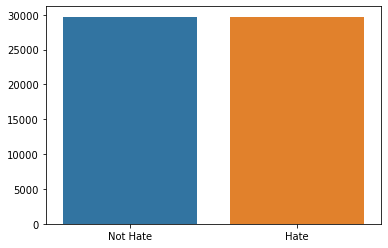

In [10]:
x = ["Not Hate", "Hate"]
y = [len(train_upsampled[train_upsampled.label == 0 ]), len(train_upsampled[train_upsampled.label == 1 ])]

sns.barplot(x, y)
plt.show()

### Creating pipeline using sklearn

In [11]:
pipeline_sgd = Pipeline([('vect', CountVectorizer()), 
                         ('tfidf',  TfidfTransformer()), 
                         ('nb', SGDClassifier()),])

pipeline_bnb = Pipeline([('vect', CountVectorizer()), 
                         ('tfidf',  TfidfTransformer()), 
                         ('nb', BernoulliNB()),])

pipeline_svc = Pipeline([('vect', CountVectorizer()), 
                         ('tfidf',  TfidfTransformer()), 
                         ('nb', SVC()),])


### Training the model 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train_upsampled['tweet'],
                                                    train_upsampled['label'],
                                                    random_state = 0)
models = []

model_sgd = pipeline_sgd.fit(X_train, y_train)
model_bnb = pipeline_bnb.fit(X_train, y_train)
model_svc = pipeline_svc.fit(X_train, y_train)

models.append({"name": "model_sgd", "model": model_sgd})
models.append({"name": "model_bnb", "model": model_bnb})
models.append({"name": "model_svc", "model": model_svc})


### Evaluating the model

In [13]:
for index in range (len(models)):
    print("Model name:", models[index]['name'])
    y_predict = models[index]['model'].predict(X_test)
    f1_score_result = f1_score(y_test, y_predict)
    accuracy_score_result = accuracy_score(y_test, y_predict)
    precision_score_result = precision_score(y_test, y_predict)

    print("F1 score %s" % round(f1_score_result*100, 2), "%")
    print("Accuracy score %s" % round(accuracy_score_result*100, 2), "%")
    print("Precision score %s" % round(precision_score_result*100, 2), "%")
    print("-----------------------")

Model name: model_sgd
F1 score 96.95 %
Accuracy score 96.92 %
Precision score 95.3 %
-----------------------
Model name: model_bnb
F1 score 96.04 %
Accuracy score 96.0 %
Precision score 94.33 %
-----------------------
Model name: model_svc
F1 score 99.77 %
Accuracy score 99.77 %
Precision score 99.57 %
-----------------------


### Saving model

In [15]:
pickle.dump(models[2]['model'], open("antagonism_model", 'wb'))

### Loading model

In [16]:
loaded_model = pickle.load(open("antagonism_model", 'rb'))

In [17]:
print(loaded_model)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('nb', SVC())])


### Testing the model

In [18]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    return text
    

In [19]:
test_data = pd.read_csv('dataset/test.csv')

for i in range (test_data.size-1):
    sampleTestTweet = test_data.iloc[i].tweet
    sampleTestTweet = clean_text(sampleTestTweet)

    output = ["Not hate", "hate"]
    result = loaded_model.predict(pd.Series(sampleTestTweet))[0]
    if(result == 1):
        print(sampleTestTweet, "<==>", output[result])
        print()

thought factory bbc neutrality on right wing fascism  politics media blm brexit trump leadership gt3  <==> hate

 chick gets fucked hottest naked lady  <==> hate

suppo the taiji fisherman no bullying no racism tweet4taiji thecove seashepherd  <==> hate

i say we because im speaking collectively ive always known 2016 showed a lot  and  <==> hate

     lt no more feeding at the public trough piggy michelleobama  <==> hate

hey   a 14000 ivanka bracelet do you feel good profiting from xenophobia misogyny hatred  grabyourwallet <==> hate

 all together this christmas pls  amp follow  national day of action on 20 feb against  amp the  <==> hate

you might be a libtard if libtard  sjw liberal politics  <==> hate

people arent protesting trump because a republican wonthey do so because trump has fuhered  amp  <==> hate

 at work attorneys for white officer who shot philandocastile remove black judge from presiding over trial  <==> hate

 trumps long history of  explained 1970s thru 2016 neve

popular youtuber adam saleh ejected from delta flight for speaking arabic   <==> hate

trumpusa they call you   homophobic misogynist  jealousy loser     when we go up  they go down  <==> hate

how is it that a man comes in last in a race but he is declared a winner putinschoice putinspuppet retweet  <==> hate

 we the people originally meant we the white landholding males       2017in3words  <==> hate

 allahsoil the bears rapacious hunger for oil also sealed its doom     teambts  <==> hate

  is this your relation yeah thats a right i see you all as the same   <==> hate

 when they call us   homophobic  misogynist  they are really saying that they are jealous of us when we go u <==> hate

   the debate stopper the blocker the white hater conversation non debater the economic migrant the scou <==> hate

hate hypocrisy  prejudice hollywood nb year review most obnoxious liberal celebrity quotes of 2016  <==> hate

  couple having sex big black women porn videos   <==> hate

 fucking rus

KeyboardInterrupt: 